**`Run the following cell to install lyricsgenius:`**

In [14]:
#!pip install lyricsgenius

**`Import Packages:`**

In [8]:
import boto3
import uuid
import time
from datetime import datetime
from decimal import *
import requests
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import re
import string
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from lyricsgenius import Genius
from Spotify_Analysis import *
import transformers as hf
from torch.utils.data import Dataset, DataLoader

import warnings
warnings.filterwarnings("ignore")

# `Calculating Similarity between Ay-Yo! User Profiles`
`Marti Heit and Emma Rainer`

## Task 1: Data Generation

### Load Glove Embeddings

In [2]:
glove = load_glove('glove.6B.300d.txt')  # dictionary

### Genius API
Leverage genius API to scrape relevant song lyrics. Using glove embeddings, find a word vector centroid for the text of a particular song.

In [35]:
genius = Genius(GENIUS_API_TOKEN) # Token stored in Spotify_Analysis.py

### Generate Sample Ay-Yo User Posts

In [81]:
lana_lyrics = get_lyrics('1949', 'Lana Del Ray', GENIUS_API_TOKEN)
olivia_lyrics = get_lyrics('deja vu', 'Olivia Rodrigo', GENIUS_API_TOKEN)
kendrick_lyrics = get_lyrics('HUMBLE.', 'Kendrick Lamar', GENIUS_API_TOKEN)

ayyo_user1 = [lana_lyrics, olivia_lyrics, kendrick_lyrics]

Searching for "1949" by Lana Del Ray...
Done.
Searching for "deja vu" by Olivia Rodrigo...
Done.
Searching for "HUMBLE." by Kendrick Lamar...
Done.


In [82]:
fiona_lyrics = get_lyrics('Sleep to Dream', 'Fiona Apple', GENIUS_API_TOKEN)
zach_lyrics = get_lyrics('Tishomingo', 'Zach Bryan', GENIUS_API_TOKEN)
chappell_lyrics = get_lyrics('Pink Pony Club', 'Chappell Roan', GENIUS_API_TOKEN)

ayyo_user2 = [fiona_lyrics, zach_lyrics, chappell_lyrics]

Searching for "Sleep to Dream" by Fiona Apple...
Done.
Searching for "Tishomingo" by Zach Bryan...
Done.
Searching for "Pink Pony Club" by Chappell Roan...
Done.


In [83]:
amine_lyrics = get_lyrics('Heebiejeebies', 'Amine', GENIUS_API_TOKEN)
kanye_lyrics = get_lyrics('No More Parties in LA', 'Kanye West', GENIUS_API_TOKEN)
mac_lyrics = get_lyrics('Weekend', 'Mac Miller', GENIUS_API_TOKEN)

ayyo_user3 = [amine_lyrics, kanye_lyrics, mac_lyrics]

Searching for "Heebiejeebies" by Amine...
Done.
Searching for "No More Parties in LA" by Kanye West...
Done.
Searching for "Weekend" by Mac Miller...
Done.


### Compare Profile Similarity

In [9]:
def compute_centroid(song_list, glove, tokenizer=None):
    '''
    The centroid of a set of vectors is the center of mass.
    '''
    vector_list = [doc2vec(lyrics, glove, tokenizer=tokenizer) for lyrics in song_list if lyrics != '']
    n = len(vector_list)
    return sum(vector_list)/n

In [7]:
user1_centroid = compute_centroid(ayyo_user1, glove)
user2_centroid = compute_centroid(ayyo_user2, glove)
user3_centroid = compute_centroid(ayyo_user3, glove)

NameError: name 'ayyo_user1' is not defined

In [19]:
def similarity_score(user1, user2):
    return np.linalg.norm(user1 - user2)

In [104]:
print('Similarity score between user 1 and user 2:', similarity_score(user1_centroid, user2_centroid))
print('Similarity score between user 1 and user 3:', similarity_score(user1_centroid, user3_centroid))
print('Similarity score between user 2 and user 3:', similarity_score(user2_centroid, user3_centroid))

Similarity score between user 1 and user 2: 1.25193
Similarity score between user 1 and user 3: 0.9190088
Similarity score between user 2 and user 3: 0.98152876


In [ ]:
## Create hash table to assign some "score" to the norm?

## Get actual posts from Ay-yo users/make a plot or something?

## Profile Similarity of Ay-Yo users

### Pull Users and Posts from Ay-Yo!

In [13]:
with open('aws_access_key.txt', 'r') as f:
     AWS_ACCESS_KEY = f.read().split('\n')[0]
with open('aws_secret_access_key.txt', 'r') as f:
     AWS_SECRET_ACCESS_KEY = f.read().split('\n')[0]

users_to_posts = get_users_to_posts(AWS_ACCESS_KEY, AWS_SECRET_ACCESS_KEY)

In [14]:
users_to_lyrics = {}
for user, post_list in users_to_posts.items():
    users_to_lyrics[user] = [get_lyrics(song, artist, GENIUS_API_TOKEN) for song, artist in post_list]

Searching for "Forever After All" by Luke Combs...
Done.
Searching for "Being In Love" by Wet Leg...
Done.
Searching for "Last Caress - C.I. Recording 1978" by Misfits...
No results found for: 'Last Caress - C.I. Recording 1978 Misfits'
Searching for "Ribs" by Lorde...
Done.
Searching for "blue" by keshi...
Done.
Searching for "I Gotta Feeling" by Black Eyed Peas...
Searching for "I Gotta Feeling" by Black Eyed Peas...
Done.
Searching for "I Love You." by Kaivon...
Done.
Searching for "Violent Crimes" by Kanye West...
Done.
Searching for "Do It To It" by ACRAZE...
Done.
Searching for "Set Me Free (feat. MAX)" by Oliver Heldens...
Done.
Searching for "less of you" by keshi...
Done.
Searching for "Down with the Sickness" by Disturbed...
Done.
Searching for "she likes spring, I prefer winter" by slchld...
Done.
Searching for "Ghost" by Justin Bieber...
Done.
Searching for "Places We Don't Know" by Kasbo...
Specified song does not contain lyrics. Rejecting.
Searching for "September" by Ear

In [49]:
class AyyoDataset(Dataset):
    def __init__(self, users_to_lyrics, word_embedding, tokenizer):
        self.users_to_lyrics = users_to_lyrics
        self.word_emb = word_embedding
        self.tokenizer = tokenizer
        
    def __len__(self):
        return len(self.users_to_lyrics)
    
    def __getitem__(self, idx):
        if isinstance(idx, int):
            key = list(self.users_to_lyrics.keys())[idx]
        else:
            key = idx
        lyrics_list = self.users_to_lyrics[key]
        centroid = compute_centroid(lyrics_list, self.word_emb, self.tokenizer)
        return key, centroid

In [22]:
user2idx = {u:i for i, u in enumerate(list(users_to_lyrics.keys()))}

#### Using Pretrained GloVe Embeddings with Custom Tokenization

In [10]:
dataset = AyyoDataset(users_to_lyrics, glove, tokenizer=None)
dataloader = DataLoader(dataset)

In [36]:
user1, centroid1 = dataset[12]
user2, centroid2 = dataset[15]
print(f"Similarity score between {user1} and {user2} is {similarity_score(centroid1, centroid2)}")

Similarity score between emmamnrainer and marti.heit is 0.3409045338630676


In [41]:
user1, centroid1 = dataset[user2idx['trenthamner']]
user2, centroid2 = dataset[user2idx['marti.heit']]
print(f"Similarity score between {user1} and {user2} is {similarity_score(centroid1, centroid2)}")

Similarity score between trenthamner and marti.heit is 0.7031075954437256


In [42]:
user1, centroid1 = dataset[user2idx['mateen_saifyan']]
user2, centroid2 = dataset[user2idx['marti.heit']]
print(f"Similarity score between {user1} and {user2} is {similarity_score(centroid1, centroid2)}")

Similarity score between mateen_saifyan and marti.heit is 0.31349149346351624


In [43]:
user1, centroid1 = dataset[user2idx['mateen_saifyan']]
user2, centroid2 = dataset[user2idx['emmamnrainer']]
print(f"Similarity score between {user1} and {user2} is {similarity_score(centroid1, centroid2)}")

Similarity score between mateen_saifyan and emmamnrainer is 0.43250492215156555


#### Using Pretrained GloVe Embeddings with Pretrained Autotokenizer 

In [16]:
tokenizer = hf.AutoTokenizer.from_pretrained('bert-base-uncased')

In [46]:
dataset = AyyoDataset(users_to_lyrics, glove, tokenizer=tokenizer)
dataloader = DataLoader(dataset)

NameError: name 'glove' is not defined

In [16]:
user1, centroid1 = dataset[12]
user2, centroid2 = dataset[15]
print(f"Similarity score between {user1} and {user2} is {similarity_score(centroid1, centroid2)}")

Similarity score between emmamnrainer and marti.heit is 0.2059921771287918


In [20]:
user1, centroid1 = dataset[user2idx['trenthamner']]
user2, centroid2 = dataset[user2idx['marti.heit']]
print(f"Similarity score between {user1} and {user2} is {similarity_score(centroid1, centroid2)}")

Similarity score between trenthamner and marti.heit is 0.4512885510921478


In [21]:
user1, centroid1 = dataset[user2idx['mateen_saifyan']]
user2, centroid2 = dataset[user2idx['marti.heit']]
print(f"Similarity score between {user1} and {user2} is {similarity_score(centroid1, centroid2)}")

Similarity score between mateen_saifyan and marti.heit is 0.1853409856557846


In [22]:
user1, centroid1 = dataset[user2idx['mateen_saifyan']]
user2, centroid2 = dataset[user2idx['emmamnrainer']]
print(f"Similarity score between {user1} and {user2} is {similarity_score(centroid1, centroid2)}")

Similarity score between mateen_saifyan and emmamnrainer is 0.23521049320697784


#### Using Different GloVe Embeddings with Pretrained Autotokenizer

In [1]:
import gensim.downloader
glove_emb = gensim.downloader.load('glove-wiki-gigaword-100')

In [50]:
dataset = AyyoDataset(users_to_lyrics, glove_emb, tokenizer=tokenizer)
dataloader = DataLoader(dataset)

In [20]:
user1, centroid1 = dataset[12]
user2, centroid2 = dataset[15]
print(f"Similarity score between {user1} and {user2} is {similarity_score(centroid1, centroid2)}")

Similarity score between emmamnrainer and marti.heit is 0.1658182591199875


In [23]:
user1, centroid1 = dataset[user2idx['trenthamner']]
user2, centroid2 = dataset[user2idx['marti.heit']]
print(f"Similarity score between {user1} and {user2} is {similarity_score(centroid1, centroid2)}")

Similarity score between trenthamner and marti.heit is 0.38902395963668823


In [24]:
user1, centroid1 = dataset[user2idx['mateen_saifyan']]
user2, centroid2 = dataset[user2idx['marti.heit']]
print(f"Similarity score between {user1} and {user2} is {similarity_score(centroid1, centroid2)}")

Similarity score between mateen_saifyan and marti.heit is 0.15167173743247986


In [25]:
user1, centroid1 = dataset[user2idx['mateen_saifyan']]
user2, centroid2 = dataset[user2idx['emmamnrainer']]
print(f"Similarity score between {user1} and {user2} is {similarity_score(centroid1, centroid2)}")

Similarity score between mateen_saifyan and emmamnrainer is 0.17738990485668182


### Find Most Similar Users

In [86]:
def get_most_similar_users(user, dataset):
    given_centroid = dataset[user][1]
    similarity_scores = []
    for other_user, centroid in DataLoader(dataset):
        similarity_scores.append((other_user[0], similarity_score(given_centroid, centroid.numpy())))
    return sorted(similarity_scores, key=lambda x: x[1])

In [84]:
user_similarity_matrix = pd.DataFrame(index=users_to_lyrics.keys(),
                                     columns=users_to_lyrics.keys())

In [89]:
for user in user_similarity_matrix.index:
    similarity_scores = get_most_similar_users(user, dataset)
    for other_user, score in similarity_scores:
        user_similarity_matrix.loc[user, other_user] = score

In [104]:
import seaborn as sns
from matplotlib import pyplot as plt

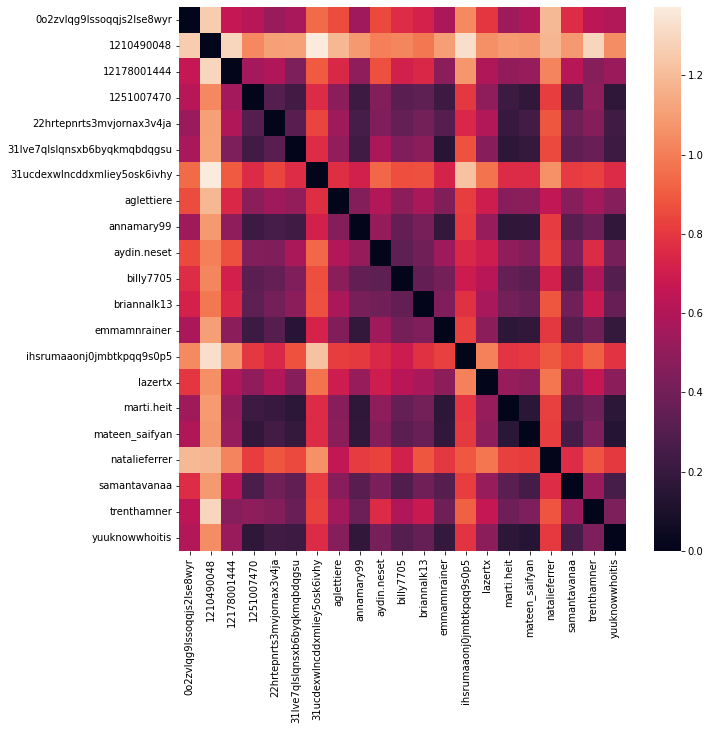

In [107]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(user_similarity_matrix.astype('float64'))
fig.show()

## Task 2: Use generated data to predict if a user will like a song

#### Generate Dataframe

So im thinking we generate data like:

features:
- unique user centroid
- new song
- 1/0 rating

In [123]:
data = {'user_embedding': [user1_centroid, user1_centroid, user1_centroid, user2_centroid, user2_centroid,\
                      user2_centroid, user3_centroid, user3_centroid,user3_centroid],
        'most_similar_user': [user2_centroid,user2_centroid,user2_centroid,user1_centroid,user1_centroid,\
                         user1_centroid, user2_centroid, user2_centroid, user2_centroid],
        'new_song': [lana_lyrics, olivia_lyrics, kendrick_lyrics, fiona_lyrics, zach_lyrics, chappell_lyrics,\
                 amine_lyrics, kanye_lyrics, mac_lyrics]}

In [125]:
df = pd.DataFrame.from_dict(data)
df['new_song'] = [doc2vec(lyrics, glove) for lyrics in df['new_song']]
df['label'] = 1
df.head()

,user_embedding,most_similar_user,new_song,label
0,"[-0.04867624, -0.046041112, -0.08815306, 0.067...","[-0.0867781, -0.042138185, -0.1209145, 0.00358...","[-0.033662993, -0.056129795, -0.08538399, -0.0...",1
1,"[-0.04867624, -0.046041112, -0.08815306, 0.067...","[-0.0867781, -0.042138185, -0.1209145, 0.00358...","[-0.12806848, -0.040105637, -0.11151454, 0.018...",1
2,"[-0.04867624, -0.046041112, -0.08815306, 0.067...","[-0.0867781, -0.042138185, -0.1209145, 0.00358...","[0.015702737, -0.04188791, -0.06756065, 0.1926...",1
3,"[-0.0867781, -0.042138185, -0.1209145, 0.00358...","[-0.04867624, -0.046041112, -0.08815306, 0.067...","[-0.116803765, -0.035361692, -0.118647344, 0.0...",1
4,"[-0.0867781, -0.042138185, -0.1209145, 0.00358...","[-0.04867624, -0.046041112, -0.08815306, 0.067...","[-0.02747917, -0.10858934, -0.068350054, 0.007...",1


#### Negative Sampling

I'm thinking that once we have a lot of sample users, we can take the user that is most dissimilar from a given user and give all of those songs a negative rating? idk 

#### Modeling

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [129]:
# Using pretrained embeddings initially? idk need to work on this

class MF(nn.Module):
    def __init__(self, num_users, num_items, emb_size=300):
        super(MF, self).__init__()
        self.n_u = num_users
        self.n_v = num_items
        
        self.user_emb = nn.Embedding(num_users, emb_size)
        self.user_bias = nn.Embedding(num_users, 1)
        
        self.item_emb = nn.Embedding(num_items, emb_size) 
        self.item_bias = nn.Embedding(num_items, 1)
        
        self.user_emb.weight.data.uniform_(0,0.05)   # range
        self.item_emb.weight.data.uniform_(0,0.05)
        
        self.user_bias.weight.data.uniform_(-0.01,0.01) # range
        self.item_bias.weight.data.uniform_(-0.01,0.01)

    def forward(self, u, v):
        b = self.user_bias(u).squeeze()
        c = self.item_bias(v).squeeze()
        U = self.user_emb(u)
        V = self.item_emb(v)
        uv = (U*V).sum(1) + b + c
        return uv